# 航空公司客户价值分析

目录

- 背景与数据源

- 特征选取

- 程序代码

- 拓展思考


背景与数据源
- 背景
    - 二八定律： 20%的客户，为企业带来约80%的利益。
    - 在企业的客户关系管理中，对客户分类，区分不同价值的客户。针对不同价值的客户提供个性化服务方案，采取不同营销策略，将有限营销资源集中于高价值客户，实现企业利润最大化目标。
    - 在竞争激烈的航空市场里，很多航空公司都推出了优惠的营销方式来吸引更多的客户。在此种环境下，如何将公司有限的资源充分利用，提示企业竞争力，为企业带来更多的利益。
- 数据源
    - 和鲸社区（航空客户价值数据集）

航空公司客户价值分析模型（LRFMC）： 
- L：会员入会时间距观测窗口结束的时间 
- R：客户最近一次乘坐公司分级距观测窗口结束的时间（月数） 
- F：客户在观测窗口内乘坐公司飞机的次数 
- M：客户在观测窗口内累计的飞行里程 
- C：客户在观测窗口内乘坐舱位所对应的折扣系数的平均值

采用K-Means聚类算法，对客户进行分群，比较不同类别客户的客户价值，从而指定相应的营销策略

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


airline_data = pd.read_csv("air_data.csv") #导入航空数据
airline_data.info()
#print('原始数据的形状为：',airline_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MEMBER_NO                62988 non-null  int64  
 1   FFP_DATE                 62988 non-null  object 
 2   FIRST_FLIGHT_DATE        62988 non-null  object 
 3   GENDER                   62985 non-null  object 
 4   FFP_TIER                 62988 non-null  int64  
 5   WORK_CITY                60719 non-null  object 
 6   WORK_PROVINCE            59740 non-null  object 
 7   WORK_COUNTRY             62962 non-null  object 
 8   AGE                      62568 non-null  float64
 9   LOAD_TIME                62988 non-null  object 
 10  FLIGHT_COUNT             62988 non-null  int64  
 11  BP_SUM                   62988 non-null  int64  
 12  EP_SUM_YR_1              62988 non-null  int64  
 13  EP_SUM_YR_2              62988 non-null  int64  
 14  SUM_YR_1              

数据集共有62988条数据，44个特征。

In [2]:
airline_data.count()

MEMBER_NO                  62988
FFP_DATE                   62988
FIRST_FLIGHT_DATE          62988
GENDER                     62985
FFP_TIER                   62988
WORK_CITY                  60719
WORK_PROVINCE              59740
WORK_COUNTRY               62962
AGE                        62568
LOAD_TIME                  62988
FLIGHT_COUNT               62988
BP_SUM                     62988
EP_SUM_YR_1                62988
EP_SUM_YR_2                62988
SUM_YR_1                   62437
SUM_YR_2                   62850
SEG_KM_SUM                 62988
WEIGHTED_SEG_KM            62988
LAST_FLIGHT_DATE           62988
AVG_FLIGHT_COUNT           62988
AVG_BP_SUM                 62988
BEGIN_TO_FIRST             62988
LAST_TO_END                62988
AVG_INTERVAL               62988
MAX_INTERVAL               62988
ADD_POINTS_SUM_YR_1        62988
ADD_POINTS_SUM_YR_2        62988
EXCHANGE_COUNT             62988
avg_discount               62988
P1Y_Flight_Count           62988
L1Y_Flight

数据集中存在票价为空但是飞行公里大于零的不合理值，但是所占比例较小，这里直接删去

In [3]:
## 去除票价为空的记录
exp1 = airline_data["SUM_YR_1"].notnull()
exp2 = airline_data["SUM_YR_2"].notnull()
exp = exp1 & exp2
airline_notnull = airline_data.loc[exp,:]
print('删除缺失记录后数据的形状为：',airline_notnull.shape)

删除缺失记录后数据的形状为： (62299, 44)


In [4]:
#只保留票价非零的，或者平均折扣率不为0且总飞行公里数大于0的记录。
index1 = airline_notnull['SUM_YR_1'] != 0
index2 = airline_notnull['SUM_YR_2'] != 0
index3 = (airline_notnull['SEG_KM_SUM']> 0) & \
    (airline_notnull['avg_discount'] != 0)  
airline = airline_notnull[(index1 | index2) & index3]
print('删除异常记录后数据的形状为：',airline.shape)

删除异常记录后数据的形状为： (62044, 44)


    数据集中存在票价为空的删除了，票价为0和平均折扣率不为0且总飞行公里数大于0的记录是不合理的，也要删除。

    删除后剩余的样本值是62044个，可见异常样本的比例不足1.5%，因此不会对分析结果产生较大的影响。

特征选取
- L = LOAD_TIME - FFP_DATE
会员入会时间距观测窗口结束的月数 = 观测窗口的结束时间 - 入会时间[单位：月]
- R = LAST_TO_END
客户最近一次乘坐公司飞机距观测窗口结束的月数 = 最后一次乘机时间至观察窗口末端时长[单位：月]
- F = FLIGHT_COUNT
客户在观测窗口内乘坐公司飞机的次数 = 观测窗口的飞行次数[单位：次]
- M = SEG_KM_SUM
客户在观测时间内在公司累计的飞行里程 = 观测窗口总飞行公里数[单位：公里]
- C = AVG_DISCOUNT
客户在观测时间内乘坐舱位所对应的折扣系数的平均值 = 平均折扣率[单位：无]

原因
- 因消费金额指标在航空公司中不适用，故选择客户在一定时间内累积的飞行里程M和客户乘坐舱位折扣系数的平均值C两个指标代替消费金额。此外，考虑航空公司会员加入时间在一定程度上能够影响客户价值，所以在模型中增加客户关系长度L，作为区分客户的另一指标，因此构建出LRFMC模型。

In [5]:
al2 = airline[["LOAD_TIME","FFP_DATE",
    "LAST_TO_END","FLIGHT_COUNT",
    "SEG_KM_SUM","avg_discount"]]
al2.head()

,LOAD_TIME,FFP_DATE,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
0,2014/03/31,2006/11/02,1,210,580717,0.961639
1,2014/03/31,2007/02/19,7,140,293678,1.252314
2,2014/03/31,2007/02/01,11,135,283712,1.254676
3,2014/03/31,2008/08/22,97,23,281336,1.090870
4,2014/03/31,2009/04/10,5,152,309928,0.970658


入会时长（L） = LOAD_TIME(截止时间) - FFP_DATE(入会时间)

In [6]:
#计算入会时长转换数据类型
L = pd.to_datetime(al2["LOAD_TIME"]) - \
pd.to_datetime(al2["FFP_DATE"])
L = L.astype("str").str.split().str[0]
L = L.astype("int")/30
## 合并特征
al3 = pd.concat([L,
    al2.iloc[:,2:]],axis = 1)
al3.columns=[u'入会时长',u'上一飞行距今',u'飞行总计',u'飞行总里程',u'平均折扣率']
al3.head()

,入会时长,上一飞行距今,飞行总计,飞行总里程,平均折扣率
0,90.200000,1,210,580717,0.961639
1,86.566667,7,140,293678,1.252314
2,87.166667,11,135,283712,1.254676
3,68.233333,97,23,281336,1.090870
4,60.533333,5,152,309928,0.970658


In [7]:
al4=(al3-al3.mean(axis=0))/al3.std(axis=0) #形成la4建模数据集，标准化处理
al4

,入会时长,上一飞行距今,飞行总计,飞行总里程,平均折扣率
0,1.435707,-0.944948,14.034016,26.761154,1.295540
1,1.307152,-0.911894,9.073213,13.126864,2.868176
2,1.328381,-0.889859,8.718869,12.653481,2.880950
3,0.658476,-0.416098,0.781585,12.540622,1.994714
4,0.386032,-0.922912,9.923636,13.898736,1.344335
...,...,...,...,...,...
62974,2.076128,-0.460169,-0.706656,-0.805297,-0.065898
62975,0.557046,-0.283886,-0.706656,-0.805297,-0.282309
62976,-0.149421,-0.735611,-0.706656,-0.772332,-2.689885
62977,-1.206173,1.605649,-0.706656,-0.779837,-2.554628


根据客户的五个指标，对客户进行聚类分群，k=5

In [8]:
from sklearn.cluster import KMeans #导入kmeans算法


k = 5
kmodel = KMeans(n_clusters=k)  #模型初始化，n_clusters为分类数，一般为cpu数
kmodel.fit(al4)

kmodel.cluster_centers_,kmodel.labels_ #聚类中心，聚类类别

(array([[ 1.16468452, -0.37815724, -0.08527927, -0.09306986, -0.15990324],
        [-0.31131564,  1.6932806 , -0.57474724, -0.53649637, -0.19263064],
        [ 0.48514132, -0.79994039,  2.4835996 ,  2.42466864,  0.31484279],
        [-0.70013748, -0.41774793, -0.15737727, -0.15613067, -0.27464002],
        [-0.01213353,  0.01473446, -0.25446195, -0.26527147,  2.04722409]]),
 array([2, 2, 2, ..., 3, 1, 1]))

In [9]:
r1=pd.Series(kmodel.labels_).value_counts() #统计各个类别的数目
r2=pd.DataFrame(kmodel.cluster_centers_)  #找出聚类中心
al5=pd.concat([r1,r2],axis=1)  #横向连接（0是纵向），得到聚类中心对应的类别下的数目
al5.columns=['聚类个数'] + list(al3.columns)
al5.head()

,聚类个数,入会时长,上一飞行距今,飞行总计,飞行总里程,平均折扣率
0,15647,1.164685,-0.378157,-0.085279,-0.093070,-0.159903
1,11981,-0.311316,1.693281,-0.574747,-0.536496,-0.192631
2,5338,0.485141,-0.799940,2.483600,2.424669,0.314843
3,24329,-0.700137,-0.417748,-0.157377,-0.156131,-0.274640
4,4749,-0.012134,0.014734,-0.254462,-0.265271,2.047224


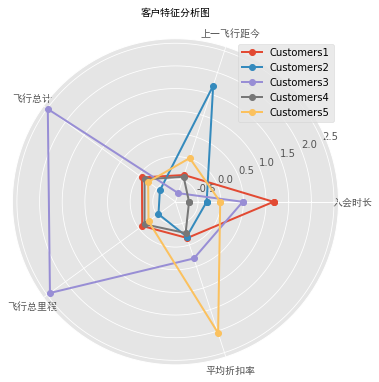

In [21]:
plt.style.use('ggplot')
plt.rcParams['font.sans-serif']='simkai'
plt.rcParams['axes.unicode_minus']=False
#标签
labels = np.array(al3.columns)
# 数据个数
dateLength=5
N=len(r2)
# 设置雷达图的角度，用于平分切开一个圆面
angles=np.linspace(0,2*np.pi,N,endpoint=False)
#封闭雷达图
data=pd.concat([r2,r2.iloc[:,0]],axis=1)
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure(figsize = (6,6))  #雷达图显示大小
ax=fig.add_subplot(111,polar=True)

for i in range(0,5):
    j=i+1
    ax.plot(angles,data.iloc[i,:],'o-',linewidth=2,label='Customers{0}'.format(j))
    
ax.set_thetagrids(angles*180/np.pi,labels,fontproperties='SimHei')  #每个特征对应的标签
ax.set_title('客户特征分析图',va='bottom',fontproperties='SimHei')  #标题
ax.set_rlim(-1,2.6)  # 设置雷达图的范围
ax.grid(True)  # 添加网格线
plt.legend()
plt.show()

价值分析 特征分析
- Customer 1： 在'入会时长'属性最大，定义为重要挽留客户
- Customer 2： 在'飞行总计' '飞行总里程'属性最小，定义为低价值客户
- Customer 3： 在'飞行总计' '飞行总里程'属性最大，定义为重要保持客户
- Customer 4： 在'飞行总计' '飞行总里程'属性上较小，定义为一般客户
- Customer 5： 在'平均折扣率'属性上最大，可定义为重要发展客户

每种客户类别的特征如下：
- 1.重要挽留客户：'平均折扣率'、'飞行总计'、'飞行总里程'较高，客户价值变化的不确定性高。应掌握客户最新信息、维持与客户的互动。
- 2.一般和低价值客户：其他属性都低、'上一次飞行距今'较高。这类客户可能在打折促销时才会选择消费。
- 3.重要保持客户：'平均折扣率'（平均折扣率较高、仓位等级较高）、'飞行总计'、'飞行总里程'较高，'上一次飞行距今'（最近乘坐航班）低。应将资源优先投放到这类客户身上，进行差异化管理，提高客户的忠诚度和满意度。
- 4.重要发展客户：'平均折扣率'较高，这类客户入会时长短、当前价值低、发展潜力大，应促使客户增加在本公司和合作伙伴处的消费。